<div class="frontmatter text-center">
<h1>Geospatial Data Science</h1>
<h2>Exercise 5: Spatial Autocorrelation</h2>
<h3>IT University of Copenhagen, Spring 2023</h3>
<h3>Instructor: Jan Leonard Schelhaas</h3>
</div>

This notebook was adapted from:
* A course on geographic data science: https://darribas.org/gds_course/content/bF/diy_F.html


## Data preparation

In this exercise we will try to detect *spatial autocorrelation* in the voting behaviour in Denmark.
The dataset is from the parliament election in 2022 on the most detailed spatial resolution called 'afstemningsområder' (*voting areas*) (similar to the polygon data set that we used in lecture 4!)

You can find the necessary data in the data subfolder. Read more about the data on the data source: https://valgdatabase.dst.dk/

The data set with number of votes for each party in each area does not include the geometries for the area.
To plot the election data with the geometries you therefore first need to join the them with a spatial dataset of all voting areas in DK.

The dataset with the geometries is from https://dataforsyningen.dk/ (a very good source to public spatial data in DK).

## Task I: Get the data ready!

To join the two datasets you need to use the columns 'ValgstedId' in the two files.

Since there are no geometries in the csv-data, there is no need to reproject the data before joining - but it is still good practice to check the crs and see if it is the one we want.
In our case the data is in a specific version of the UTM crs usually used for Denmark.

When the data are ready, complete all the other parts required for the ESDA analysis of spatial autocorrelation:

- Make sure your geography does not have islands (either by removing them or using a method which does not create islands in our data set)
- Create a spatial weights matrix
- Standardise the spatial weights matrix
- Create a standardised version of the data/column you are working with
- Create the spatial lag of the number of votes in the voting areas

**When creating your spatial weights matrix, think of one criterium to build it that you think would fit this variable (e.g. contiguity, distance-based, etc.), and apply it.**

**The data set on votes in each area contains columns with votes for each party, number of people entitled to vote, etc. You have to choose yourself which part of the data you want to do your analysis on. It might be a good idea to convert all total numbers to percentage.**


In [1]:
import seaborn as sns
import pandas as pd
import esda
from pysal.lib import weights
from splot.esda import (
    plot_moran, moran_scatterplot, lisa_cluster, plot_local_autocorrelation,
)
from splot.libpysal import plot_spatial_weights
import geopandas as gpd
import numpy as np
import contextily as cx
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
/opt/conda/lib/python3.9/site-packages/esda/getisord.py:636: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if __name__ is "__main__":


In [2]:
# Read data

fp_votes = './data/election_data.csv'
fp_geom = './data/voting_areas.gpkg'

votes = pd.read_csv(fp_votes, sep=';', encoding='utf-8')
geoms = gpd.read_file(fp_geom)

In [3]:
# inspect "votes" data set
votes.sample(5)

,Gruppe,ValgstedId,KredsNr,StorKredsNr,LandsdelsNr,FV2022 - Stemmeberettigede,FV2022 - Afgivne stemmer,FV2022 - Blanke stemmer,FV2022 - Andre ugyldige stemmer,FV2022 - Gyldige stemmer,...,FV2022 - M. Minoritetspartiet,FV2022 - O. Dansk Folkeparti,"FV2022 - Q. Frie Grønne, Danmarks Nye Venstrefløjsparti","FV2022 - V. Venstre, Danmarks Liberale Parti",FV2022 - Æ. Danmarksdemokraterne - Inger Støjberg,FV2022 - Ø. Enhedslisten - De Rød-Grønne,FV2022 - Å. Alternativet,FV2022 - 1. Uden for partierne,FV2022 - 2. Uden for partierne,FV2022 - 3. Uden for partierne
398,360003,360003,29,5,2,1928,1461,20,11,1430,...,101,99,2,151,144,39,13,4,4,-
75,155001,155001,12,1,1,3812,3416,20,13,3383,...,509,88,4,443,110,103,96,1,0,-
1225,813008,813008,84,10,3,1567,1347,8,10,1329,...,92,37,0,219,250,17,15,1,-,-
500,420004,420004,44,6,2,693,577,7,1,569,...,45,19,0,84,76,22,11,1,-,-
361,330005,330005,40,5,2,5994,4864,63,27,4774,...,445,201,10,482,442,102,67,6,3,-


In [4]:
# inspect "geoms" data set
geoms.sample(5)

,local_id,voting_name,municipal_id,area_name,ValgstedId,geometry
59,05,Dansborghallen,0167,Dansborghallen,167005,MULTIPOLYGON Z (((720337.990 6171698.540 0.000...
818,08,Avedøre Idrætscenter,0167,Avedøre Idrætscenter,167008,MULTIPOLYGON Z (((715599.290 6171384.830 0.000...
929,15,Valdemarshus,0580,Padborg,580015,MULTIPOLYGON Z (((515111.800 6076477.150 0.000...
994,08,Kirkehuset,0727,Hundslund,727008,MULTIPOLYGON Z (((567203.020 6201750.880 0.000...
561,06,Ingstrup Forsamlingshus,0849,Ingstrup,849006,MULTIPOLYGON Z (((538440.430 6351624.250 0.000...


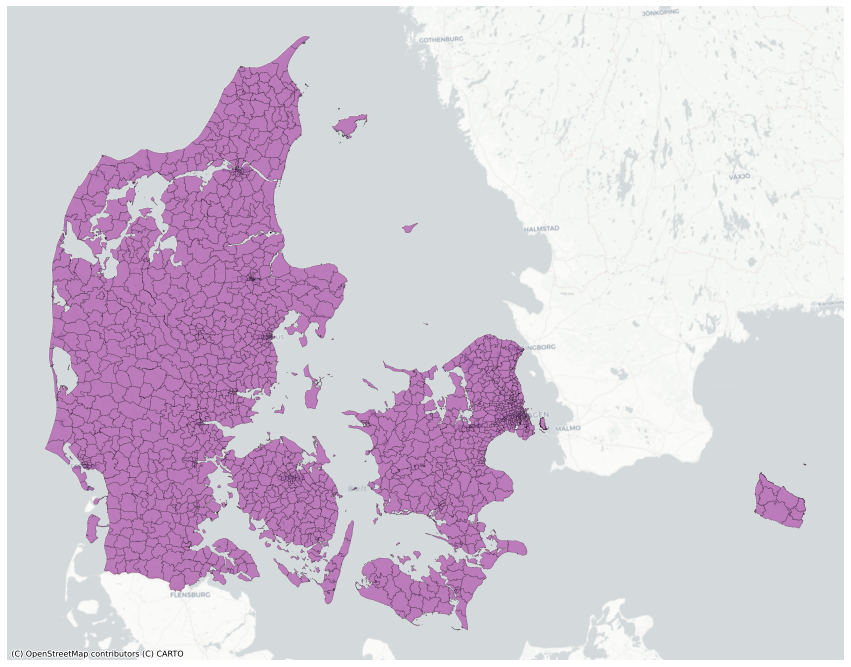

In [6]:
# easy overview plot of the geoms

ax = geoms.plot(facecolor='purple', edgecolor='black', alpha=0.5, figsize=(15,15), linewidth=0.3)

cx.add_basemap(ax, crs=geoms.crs, source=cx.providers.CartoDB.Positron)

ax.set_axis_off()

In [7]:
# Check crs
geoms.crs

<Derived Projected CRS: EPSG:25832>
Name: ETRS89 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe between 6°E and 12°E: Austria; Belgium; Denmark - onshore and offshore; Germany - onshore and offshore; Norway including - onshore and offshore; Spain - offshore.
- bounds: (6.0, 38.76, 12.0, 84.33)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [8]:
# combine geoms and votes dataframes into "v_areas";
# inner join to not include potential NAs

v_areas = geoms.merge(votes, on = "ValgstedId", how = "inner")

v_areas.set_index('ValgstedId',drop=False,inplace=True)

# Make sure that all votes and geometris have been joined
assert len(v_areas) == len(votes) == len(geoms)

# other way of joining the dfs:
# v_areas = geoms.join(votes.set_index('ValgstedId'), on='ValgstedId', how='inner')

v_areas.head()

,local_id,voting_name,municipal_id,area_name,ValgstedId,geometry,Gruppe,KredsNr,StorKredsNr,LandsdelsNr,...,FV2022 - M. Minoritetspartiet,FV2022 - O. Dansk Folkeparti,"FV2022 - Q. Frie Grønne, Danmarks Nye Venstrefløjsparti","FV2022 - V. Venstre, Danmarks Liberale Parti",FV2022 - Æ. Danmarksdemokraterne - Inger Støjberg,FV2022 - Ø. Enhedslisten - De Rød-Grønne,FV2022 - Å. Alternativet,FV2022 - 1. Uden for partierne,FV2022 - 2. Uden for partierne,FV2022 - 3. Uden for partierne
ValgstedId,,,,,,,,,,,,,,,,,,,,,
657017,17,Hammerum-Gjellerup Hall'n,0657,Hammerum,657017,MULTIPOLYGON Z (((499898.900 6224849.820 0.000...,657017,81,9,3,...,466,91,30,1243,598,98,73,5,-,-
657015,15,Gullestrup Sport og Kultur,0657,Gullestrup,657015,MULTIPOLYGON Z (((496037.860 6226101.190 0.000...,657015,81,9,3,...,60,32,23,157,110,64,30,3,-,-
657008,08,Sdr. Felding Hallen,0657,Sdr. Felding,657008,MULTIPOLYGON Z (((483026.180 6200592.380 0.000...,657008,80,9,3,...,87,27,2,288,293,21,6,0,-,-
657027,27,Vildbjerg Sports- og Kulturcenter,0657,Vildbjerg,657027,MULTIPOLYGON Z (((477917.280 6229128.160 0.000...,657027,81,9,3,...,200,54,7,765,462,25,25,1,-,-
210008,08,Længen,0210,Karlebo,210008,MULTIPOLYGON Z (((710547.580 6203125.960 0.000...,210008,22,3,1,...,104,12,1,133,43,21,29,0,0,-


### Selected for analysis: % of votes for Enhedslisten

In [9]:
### Selected for analysis: % of votes for Enhedslisten

# add % column to v_areas 
v_areas['pct_enhed'] = v_areas['FV2022 - Ø. Enhedslisten - De Rød-Grønne'] / v_areas['FV2022 - Afgivne stemmer'] * 100

# Create standardized version of vote counts (subtract mean and divide by standard deviation)
v_areas['pct_enhed_std'] = (
    v_areas['pct_enhed'] - v_areas['pct_enhed'].mean()
) / v_areas['pct_enhed'].std()


In [10]:
# Create weights (k=8 nearest neighbours) and check for islands
wk = weights.KNN.from_dataframe(v_areas, k=5)
assert len(wk.islands) == 0

# Standardize spatial weights matrix
wk.transform = 'R' # Using row standardization

print(sum(wk[657017].values())) # Now the sum of each feature's weights should sum to one

1.0


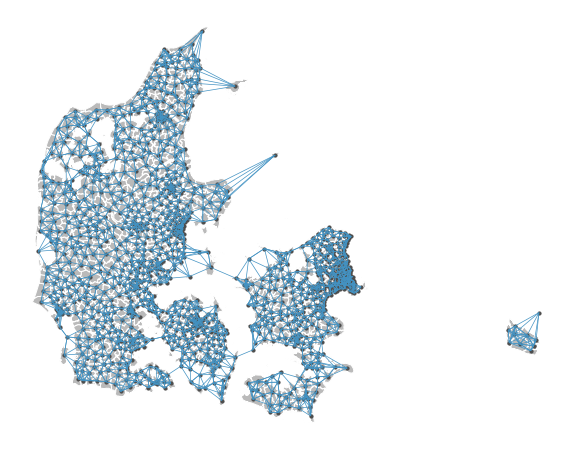

In [11]:
plot_spatial_weights(wk, v_areas, indexed_on='ValgstedId');

In [12]:
# Create spatial lag of case numbers
v_areas['w_pct_enhed_std'] = weights.lag_spatial(wk, v_areas['pct_enhed_std'])
v_areas[['pct_enhed_std','w_pct_enhed_std']].head()

,pct_enhed_std,w_pct_enhed_std
ValgstedId,,
657017,-0.602837,-0.323312
657015,0.576476,-0.623831
657008,-0.687669,-0.636620
657027,-0.879073,-0.754130
210008,-0.363172,-0.113998


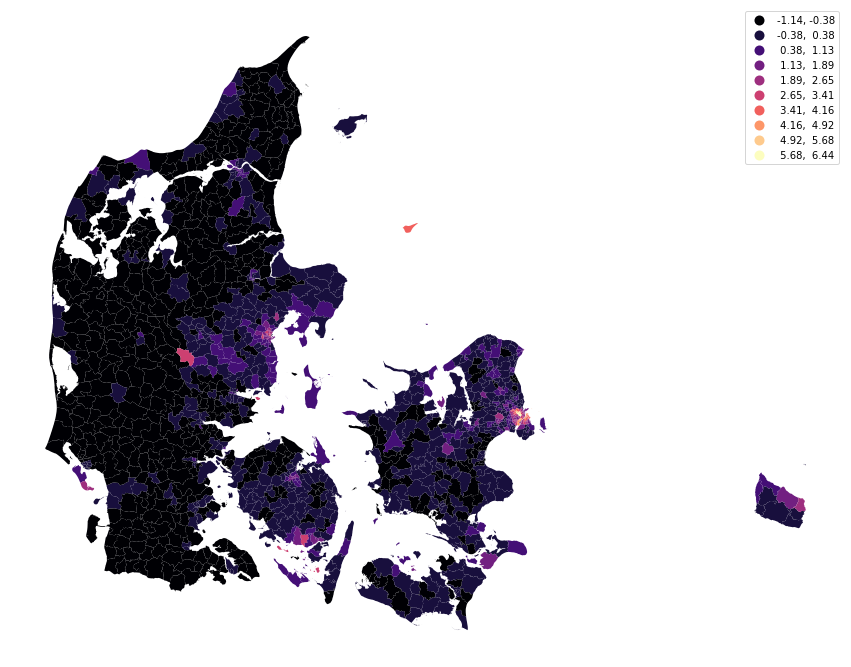

In [13]:
# plot standardized vote percentages
ax = v_areas.plot(column='pct_enhed_std', 
             scheme='equal_interval', 
             k=10, 
             cmap='magma', 
             legend=True, 
             figsize=(15,15))
ax.set_axis_off()

## Task II: Global spatial autocorrelation

Let's move on to the analytics:

- Visualise your data score with a Moran Plot
- Calculate Moran's I
- **What conclusions can you reach from the Moran Plot and Moran's I? What's the main spatial pattern?**

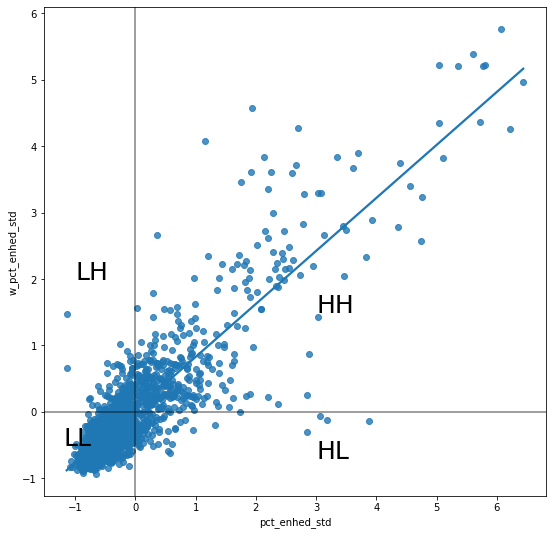

In [14]:
# Visualise with a Moran Plot

f, ax = plt.subplots(1, figsize=(9, 9))

# regression plot (function from seaborn):
sns.regplot(x='pct_enhed_std', y='w_pct_enhed_std', data=v_areas, ci=None)

# add lines through 0,0
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)

# OBS! The placement of the text is customized to this specific plot and the range of the axes
plt.text(3, 1.5, "HH", fontsize=25)
plt.text(3, -0.7, "HL", fontsize=25)
plt.text(-1, 2, "LH", fontsize=25)
plt.text(-1.2, -0.5, "LL", fontsize=25)

plt.show()

Moran's I: 0.7979119132747186
P-value for the Moran's I statistic: 0.001


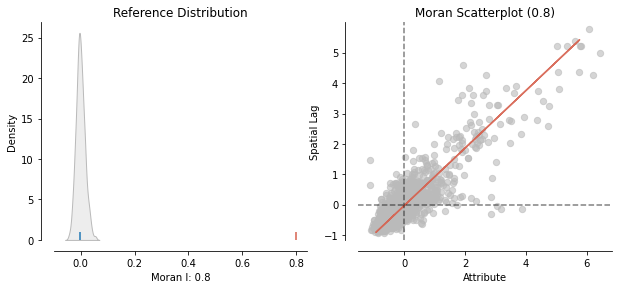

In [15]:
# Calculate Moran's I

mi = esda.Moran(v_areas['pct_enhed'], wk)

print("Moran's I:", mi.I)

print("P-value for the Moran's I statistic:", mi.p_sim)

# ready-implemented function for Moran scatterplot
plot_moran(mi);

### Interpretation

Our plots displays a positive relationship between the two variables (i.e. between the standardized value for percent votes for the party and the spatial lag values, which can be interpreted as the average of the neighbour's voting behaviours).

The relationship is not perfectly linear, but looking at the Moran's I and the p-value for Moran's I we can nevertheless state that there is a stronger pattern with similar values being close together, than if the values had been randomly distributed.

Areas with many votes for this party thus tends to be surrounded by other areas which also have many votes for this party, and vice versa.
We thus has a case of (global) spatial autocorrelation.


## Task III: Local spatial autocorrelation

Now that you have a good sense of the overall pattern in the dataset, let's move to the local scale:

1. Calculate LISA (Local Indicators of Spatial Association) statistics for the voting areas using a variable of your choice.
    - *How many of the voting areas have a significant LISA value at p=0.05?*
2. Use a KDE plot to inspect the distribution of LISA values. 
    - *Can you say something about the general pattern from this alone?*
3. How many voting areas are in each of the four quadrants, at p=0.05? (low-low, high-high, high-low, low-low)
3. Make a map of significant clusters at the 5%.
    - Can you identify hotspots or coldspots? If so, what do they mean? What about spatial outliers?
4. Create cluster maps for significance levels 0.5, 1% and 5% and compare them. 
    - *What are the main changes? Why?*
5. *Do the results confirm your impression of voting patterns in Denmark?*

**TIPS:**

- esda.Moran_Local() returns an object with several attributes! See: https://pysal.org/esda/generated/esda.Moran_Local.html 

- splot.esda.lisa_cluster takes the p-value as parameter! (default: 5%): https://splot.readthedocs.io/en/latest/generated/splot.esda.lisa_cluster.html

- `lisa.q` (if lisa is the object returned by esda.Moran_Local()) returns the quadrant of each object - but without considering the significance

### 1. LISA statistics

In [16]:
# 1. LISA statistics

# input to esda.Moran_Local:
# y is attribute array; w is weight instance assumed to be aligned with y
lisa = esda.Moran_Local(y = v_areas['pct_enhed'], 
                        w = wk)

### 2. KDE Plot for LISA values

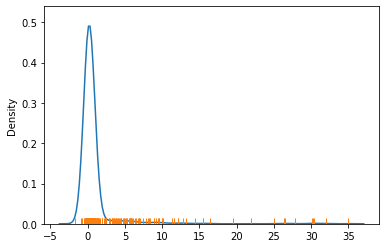

In [17]:
# Draw KDE line
ax = sns.kdeplot(lisa.Is)
# Add one small bar (rug) for each observation
# along horizontal axis
sns.rugplot(lisa.Is, ax=ax);

In [18]:
# Compute how many areas have a significant LISA value
print(f"{(lisa.p_sim < 0.05).sum() * 100 / len(lisa.p_sim):.2f}% of the voting areas have a significant value for local Moran's I at p = 0.05")

32.37% of the voting areas have a significant value for local Moran's I at p = 0.05


#### Interpretation

The figure reveals a somewhat skewed distribution of local Moran’s I statistics with a low but very long right tail. This outcome is due to the dominance of positive forms of spatial association, implying most of the local statistic values will be positive. Here it is important to keep in mind that the high positive values arise from value similarity in space, and this can be due to either high values being next to high values or low values next to low values. The local values alone cannot distinguish these two cases.

The values in the left tail of the density represent locations displaying negative spatial association. There are also two forms, a high value surrounded by low values, or a low value surrounded by high valued neighboring observations. And, again, the statistic cannot distinguish between the two cases.

From this plot alone we cannot say if we have a lot of low-low or high-high clusters, but we know that 1) most of our data do not appear to be clustered (value around 0) and that we have very few outliers (left tail) - i.e. few areas with a different voting pattern than their surroundings.

### 3. Find number of voting areas in each of the four quadrants

In [19]:
# 3. Find 

# Assign pseudo P-values to `db`
v_areas["p-sim"] = lisa.p_sim
# `1` if significant (at 5% confidence level), `0` otherwise
sig = 1 * (lisa.p_sim < 0.05)
# Assign significance flag to `db`
v_areas["sig"] = sig
# Print top of the table to inspect
v_areas[["sig", "p-sim"]].head()

,sig,p-sim
ValgstedId,,
657017,0,0.266
657015,1,0.022
657008,1,0.019
657027,1,0.003
210008,0,0.481


In [20]:
# Pick as part of a quadrant only significant polygons,
# assign `0` otherwise (Non-significant polygons)
spots = lisa.q * sig
# Mapping from value to name (as a dict)
spots_labels = {
    0: "Non-Significant",
    1: "HH",
    2: "LH",
    3: "LL",
    4: "HL",
}
# Create column in `db` with labels for each polygon
v_areas["labels"] = pd.Series(
    # First initialise a Series using values and `db` index
    spots,
    index=v_areas.index
    # Then map each value to corresponding label based
    # on the `spots_labels` mapping
).map(spots_labels)
# Print top for inspection
v_areas.labels.value_counts()

Non-Significant    911
LL                 308
HH                 124
HL                   2
LH                   2
Name: labels, dtype: int64

### 4. LISA Clusters

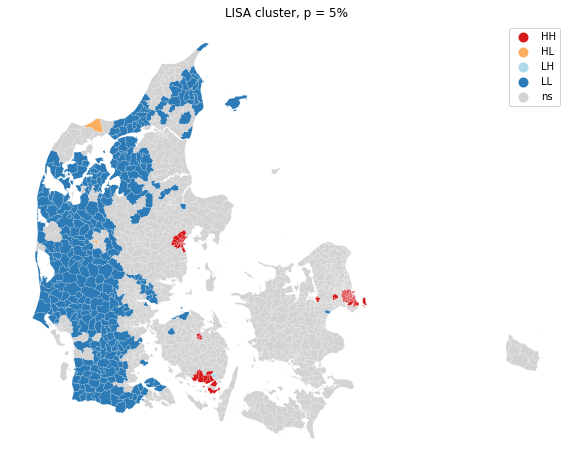

In [21]:
fig, ax = plt.subplots(1, figsize=(10,10))

lisa_cluster(lisa, v_areas, ax=ax)

plt.title("LISA cluster, p = 5%");

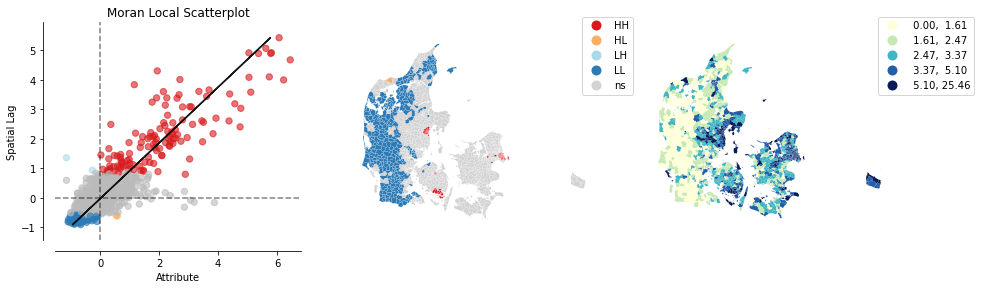

In [22]:
plot_local_autocorrelation(lisa, v_areas, 'pct_enhed');

#### Interpretation
The LISA map is in a way a simplified choropleth map of the values - it shows a simplifed and generalized picture of where there are respectively areas with clusters of high or low values.

For the percentage used here we see clusters of HH (hotspots) in the larger cities and around south of Funen. Meanwhile some of the areas south of Cph belong to a LL cluster - low values surronded by other low values (coldspots).
Finally, there are a few HL areas in Jutland - i.e. voting areas with a high value surrounded by low values (outliers).

### 5. Comparison of LISA clusters at different significance levels

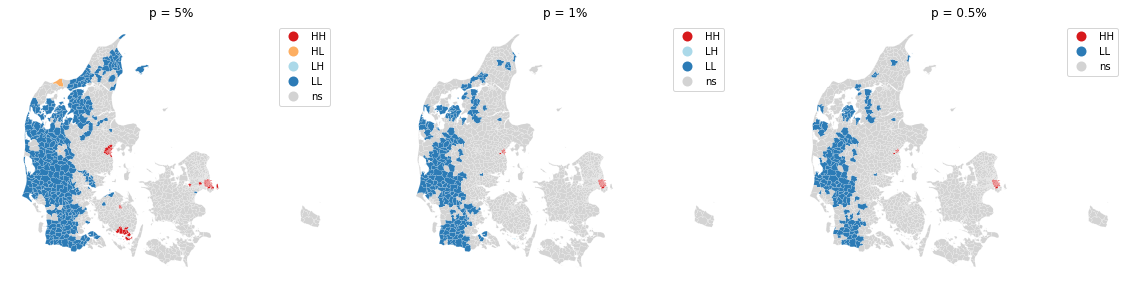

In [23]:
fig, axs = plt.subplots(1, 3, figsize = (20,20))

lisa_cluster(lisa, v_areas, 0.05, ax=axs[0])
axs[0].set_title('p = 5%')

lisa_cluster(lisa, v_areas, 0.01, ax=axs[1])
axs[1].set_title('p = 1%')

lisa_cluster(lisa, v_areas, 0.005, ax=axs[2])
axs[2].set_title('p = 0.5%')

plt.show()

#### Interpretation
The smaller the p-value, the lower is our threshold for statistical significance. So, the lower the p-value, the lower is the  likelihood of getting the same spatial pattern randomly. Comparing the cluster plots for the p-values, we can see that the LISA analysis with a p-value of 1% classifies more areas as statistically not significant, and finds fewer hotspots/coldspots, than the LISA analysis with a p-value of 10%. 